### 궁금한 것,,
변수가 많을 때 차원축소를 하면 <mark>군집분석의 성능이 올라가나?</mark>

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'].insert(0, 'AppleGothic') 

import geopandas as gpd
import geopy
from shapely.geometry import Polygon,Point 
from shapely.wkt import dumps, loads
from pyproj import Proj, transform

import descartes

## 주민등록인구, 성연령 유동인구로 동 군집화 시도

In [0]:
# flow_all = pd.DataFrame()
# for i in [804, 805, 806, 807, 808, 809, 810, 811, 812, 901, 902, 903]:
#     filepath = '/Users/Neun/Desktop/bigcon/innovation/유동인구데이터/성연령유동/노원_종로_FLOW_AGE_201{}.CSV'.format(i)
#     temp = pd.read_csv(filepath, delimiter = '|')
#     flow_all = pd.concat([flow_all, temp], axis=0, ignore_index=True)
    


In [0]:
# flow_togroup = flow_all.pivot_table(index = 'HDONG_NM', values = ['MAN_FLOW_POP_CNT_0004',
#        'MAN_FLOW_POP_CNT_0509', 'MAN_FLOW_POP_CNT_1014',
#        'MAN_FLOW_POP_CNT_1519', 'MAN_FLOW_POP_CNT_2024',
#        'MAN_FLOW_POP_CNT_2529', 'MAN_FLOW_POP_CNT_3034',
#        'MAN_FLOW_POP_CNT_3539', 'MAN_FLOW_POP_CNT_4044',
#        'MAN_FLOW_POP_CNT_4549', 'MAN_FLOW_POP_CNT_5054',
#        'MAN_FLOW_POP_CNT_5559', 'MAN_FLOW_POP_CNT_6064',
#        'MAN_FLOW_POP_CNT_6569', 'MAN_FLOW_POP_CNT_70U',
#        'WMAN_FLOW_POP_CNT_0004', 'WMAN_FLOW_POP_CNT_0509',
#        'WMAN_FLOW_POP_CNT_1014', 'WMAN_FLOW_POP_CNT_1519',
#        'WMAN_FLOW_POP_CNT_2024', 'WMAN_FLOW_POP_CNT_2529',
#        'WMAN_FLOW_POP_CNT_3034', 'WMAN_FLOW_POP_CNT_3539',
#        'WMAN_FLOW_POP_CNT_4044', 'WMAN_FLOW_POP_CNT_4549',
#        'WMAN_FLOW_POP_CNT_5054', 'WMAN_FLOW_POP_CNT_5559',
#        'WMAN_FLOW_POP_CNT_6064', 'WMAN_FLOW_POP_CNT_6569',
#        'WMAN_FLOW_POP_CNT_70U'], aggfunc = 'mean')

## 주민등록인구?

In [0]:
# 주민등록인구 데이터 적재
# 1. 구별 소계, 성별 소계 삭제
# 2. 종로구, 노원구만 남김
people = pd.read_excel('/Users/Neun/Desktop/bigcon/innovation/주민등록인구.xls', skiprows = [1,2,3])
people = people.drop(people.index[(people['동'] == '소계') | (people['구분'] == '계')])
people = people[people['자치구'].isin(['종로구', '노원구'])].drop('기간', axis = 1)
people.drop('자치구', axis = 1, inplace =True)
people.head()

,동,구분,계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,...,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95~99세,100세 이상+
4,사직동,남자,4108.0,157.5,197.5,173.5,190.5,215.5,292.0,305.0,...,328.0,270.5,182.5,163.5,155.5,108.5,40.5,17.5,2.5,1
5,사직동,여자,4920.0,150.0,181.0,186.5,210.5,277.0,329.0,373.5,...,380.0,313.5,234.5,198.5,197.0,148.0,68.5,25,9.5,2
7,삼청동,남자,1276.5,29.5,42.5,56.0,70.0,76.0,91.0,81.0,...,108.5,93.5,74.5,59.0,54.0,28.0,18.5,6,2,-
8,삼청동,여자,1434.0,33.0,38.0,44.0,52.0,97.0,85.5,95.0,...,130.5,105.5,74.0,79.0,77.5,54.0,26.0,9.5,3,2
10,부암동,남자,4772.5,120.0,200.5,242.5,277.5,387.0,381.5,269.0,...,392.5,315.5,209.5,196.5,160.0,98.5,46.5,10.5,2,-


In [0]:
people_man = people[people['구분'] == '남자'].drop('계', axis = 1)
people_woman = people[people['구분'] == '여자'].drop('계', axis = 1)

In [0]:
people_man.columns

Index(['동', '구분', '0~4세', '5~9세', '10~14세', '15~19세', '20~24세', '25~29세',
       '30~34세', '35~39세', '40~44세', '45~49세', '50~54세', '55~59세', '60~64세',
       '65~69세', '70~74세', '75~79세', '80~84세', '85~89세', '90~94세', '95~99세',
       '100세 이상+'],
      dtype='object')

In [0]:
colnames =['동', '구분'] + ['남_' + i.split('~')[0] for i in people_man.columns[2:]]
# colnames
people_man.columns = colnames
people_man.columns

Index(['동', '구분', '남_0', '남_5', '남_10', '남_15', '남_20', '남_25', '남_30', '남_35',
       '남_40', '남_45', '남_50', '남_55', '남_60', '남_65', '남_70', '남_75', '남_80',
       '남_85', '남_90', '남_95', '남_100세 이상+'],
      dtype='object')

In [0]:
colnames =['동', '구분'] + ['여_' + i.split('~')[0] for i in people_woman.columns[2:]]
# colnames
people_woman.columns = colnames
people_woman.columns

Index(['동', '구분', '여_0', '여_5', '여_10', '여_15', '여_20', '여_25', '여_30', '여_35',
       '여_40', '여_45', '여_50', '여_55', '여_60', '여_65', '여_70', '여_75', '여_80',
       '여_85', '여_90', '여_95', '여_100세 이상+'],
      dtype='object')

In [0]:
people_togroup = pd.merge(people_woman, people_man, on = '동')

In [0]:
people_togroup.drop(['구분_x', '구분_y'],axis=1, inplace=True)

In [0]:
people_togroup.info()  # 90세, 95세, 100세 이상 '-' 값 0으로 바꿔줘야 함

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 43 columns):
동             36 non-null object
여_0           36 non-null float64
여_5           36 non-null float64
여_10          36 non-null float64
여_15          36 non-null float64
여_20          36 non-null float64
여_25          36 non-null float64
여_30          36 non-null float64
여_35          36 non-null float64
여_40          36 non-null float64
여_45          36 non-null float64
여_50          36 non-null float64
여_55          36 non-null float64
여_60          36 non-null float64
여_65          36 non-null float64
여_70          36 non-null float64
여_75          36 non-null float64
여_80          36 non-null float64
여_85          36 non-null float64
여_90          36 non-null object
여_95          36 non-null object
여_100세 이상+    36 non-null object
남_0           36 non-null float64
남_5           36 non-null float64
남_10          36 non-null float64
남_15          36 non-null float64
남_20          36 

In [0]:
people_togroup['여_90'] = people_togroup['여_90'].replace('-', 0)
people_togroup['여_95'] = people_togroup['여_95'].replace('-', 0)
people_togroup['여_100세 이상+'] = people_togroup['여_100세 이상+'].replace('-', 0)

people_togroup['남_90'] = people_togroup['남_90'].replace('-', 0)
people_togroup['남_95'] = people_togroup['남_95'].replace('-', 0)
people_togroup['남_100세 이상+'] = people_togroup['남_100세 이상+'].replace('-', 0)

people_togroup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 35
Data columns (total 43 columns):
동             36 non-null object
여_0           36 non-null float64
여_5           36 non-null float64
여_10          36 non-null float64
여_15          36 non-null float64
여_20          36 non-null float64
여_25          36 non-null float64
여_30          36 non-null float64
여_35          36 non-null float64
여_40          36 non-null float64
여_45          36 non-null float64
여_50          36 non-null float64
여_55          36 non-null float64
여_60          36 non-null float64
여_65          36 non-null float64
여_70          36 non-null float64
여_75          36 non-null float64
여_80          36 non-null float64
여_85          36 non-null float64
여_90          36 non-null float64
여_95          36 non-null float64
여_100세 이상+    36 non-null float64
남_0           36 non-null float64
남_5           36 non-null float64
남_10          36 non-null float64
남_15          36 non-null float64
남_20          

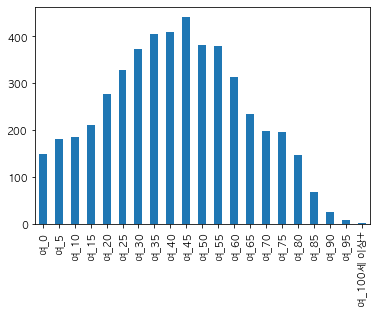

In [0]:
people_togroup.loc[0, '여_0':'여_100세 이상+'].plot(kind ='bar')

In [0]:
# people_togroup['여_65+'] = people_togroup.loc[:, '여_65' : '여_100세 이상+'].sum(axis = 1)
# people_togroup['남_65+'] = people_togroup.loc[:, '남_65' : '남_100세 이상+'].sum(axis = 1)

# people_togroup.drop(['여_65', '여_70', '여_75', '여_80', '여_85', '여_90', '여_95', '여_100세 이상+',
#                     '남_65' ,'남_70' ,'남_75' ,'남_80' ,'남_85' ,'남_90', '남_95', '남_100세 이상+'], axis = 1, inplace = True)

In [0]:
# people_togroup['여_85+'] = people_togroup.loc[:, '여_85' : '여_100세 이상+'].sum(axis = 1)
# people_togroup['남_85+'] = people_togroup.loc[:, '남_85' : '남_100세 이상+'].sum(axis = 1)

# people_togroup.drop(['여_85', '여_90', '여_95', '여_100세 이상+',
#                     '남_85' ,'남_90', '남_95', '남_100세 이상+'], axis = 1, inplace = True)

In [0]:
len(people_togroup.columns)

43

In [0]:
people_togroup.head()

,동,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,...,남_55,남_60,남_65,남_70,남_75,남_80,남_85,남_90,남_95,남_100세 이상+
0,사직동,150.0,181.0,186.5,210.5,277.0,329.0,373.5,405.0,408.5,...,328.0,270.5,182.5,163.5,155.5,108.5,40.5,17.5,2.5,1.0
1,삼청동,33.0,38.0,44.0,52.0,97.0,85.5,95.0,119.5,84.5,...,108.5,93.5,74.5,59.0,54.0,28.0,18.5,6.0,2.0,0.0
2,부암동,114.5,153.5,196.5,266.5,320.5,310.0,307.5,367.5,400.5,...,392.5,315.5,209.5,196.5,160.0,98.5,46.5,10.5,2.0,0.0
3,평창동,285.0,331.5,371.0,546.5,702.5,583.0,551.0,675.5,686.5,...,783.0,603.0,399.5,294.0,287.0,171.0,76.0,21.0,6.5,1.5
4,무악동,152.0,224.0,247.5,295.0,264.5,222.5,199.5,295.5,359.0,...,313.5,236.0,158.5,126.5,109.5,69.5,26.5,6.0,1.0,0.0


In [0]:
people_togroup.columns

Index(['동', '여_0', '여_5', '여_10', '여_15', '여_20', '여_25', '여_30', '여_35',
       '여_40', '여_45', '여_50', '여_55', '여_60', '여_65', '여_70', '여_75', '여_80',
       '여_85', '여_90', '여_95', '여_100세 이상+', '남_0', '남_5', '남_10', '남_15',
       '남_20', '남_25', '남_30', '남_35', '남_40', '남_45', '남_50', '남_55', '남_60',
       '남_65', '남_70', '남_75', '남_80', '남_85', '남_90', '남_95', '남_100세 이상+'],
      dtype='object')

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing

In [0]:
people_togroup.set_index('동', inplace = True)
people_togroup.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,남_55,남_60,남_65,남_70,남_75,남_80,남_85,남_90,남_95,남_100세 이상+
동,,,,,,,,,,,,,,,,,,,,,
사직동,150.0,181.0,186.5,210.5,277.0,329.0,373.5,405.0,408.5,441.5,...,328.0,270.5,182.5,163.5,155.5,108.5,40.5,17.5,2.5,1.0
삼청동,33.0,38.0,44.0,52.0,97.0,85.5,95.0,119.5,84.5,107.5,...,108.5,93.5,74.5,59.0,54.0,28.0,18.5,6.0,2.0,0.0
부암동,114.5,153.5,196.5,266.5,320.5,310.0,307.5,367.5,400.5,518.5,...,392.5,315.5,209.5,196.5,160.0,98.5,46.5,10.5,2.0,0.0
평창동,285.0,331.5,371.0,546.5,702.5,583.0,551.0,675.5,686.5,946.0,...,783.0,603.0,399.5,294.0,287.0,171.0,76.0,21.0,6.5,1.5
무악동,152.0,224.0,247.5,295.0,264.5,222.5,199.5,295.5,359.0,432.0,...,313.5,236.0,158.5,126.5,109.5,69.5,26.5,6.0,1.0,0.0


In [0]:
people_standard = preprocessing.scale(people_togroup)
people_standard = pd.DataFrame(people_standard, index = people_togroup.index, columns = people_togroup.columns)
people_standard.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,남_55,남_60,남_65,남_70,남_75,남_80,남_85,남_90,남_95,남_100세 이상+
동,,,,,,,,,,,,,,,,,,,,,
사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,-0.829253,...,-0.981907,-0.924136,-0.891417,-0.782528,-0.669544,-0.263661,-0.390788,0.588331,-0.331163,1.836799
삼청동,-1.131393,-1.265648,-1.153329,-1.262104,-1.314888,-1.481069,-1.292486,-1.254451,-1.365649,-1.372851,...,-1.489514,-1.407521,-1.314156,-1.368665,-1.405558,-1.462234,-1.169414,-1.170289,-0.560430,-0.483368
부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,-0.703933,...,-0.832747,-0.801242,-0.785732,-0.597432,-0.636913,-0.412552,-0.178435,-0.482134,-0.560430,-0.483368
평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,-0.008160,...,0.070308,-0.016082,-0.042024,-0.050559,0.284012,0.666908,0.865632,1.123563,1.502971,2.996883
무악동,-0.623227,-0.528903,-0.538410,-0.673665,-0.952827,-1.113078,-1.024256,-0.878098,-0.812992,-0.844715,...,-1.015439,-1.018355,-0.985359,-0.990060,-1.003107,-0.844337,-0.886277,-1.170289,-1.018964,-0.483368


In [0]:
# flow_standard = preprocessing.scale(flow_togroup)
# flow_standard = pd.DataFrame(flow_standard, index = flow_togroup.index, columns = flow_togroup.columns).reset_index()
# flow_standard.head()

In [0]:
# people_total = pd.merge(people_standard.reset_index(), flow_standard, left_on = '동', right_on = 'HDONG_NM', how = 'inner')
# people_total.drop('HDONG_NM', axis = 1, inplace = True)
# people_total.set_index('동', inplace = True)
# people_total.head()

In [0]:
# people_total.index

In [0]:
# people_total.drop(['무악동', '삼청동', '상계8동', '상계9동', '숭인1동', '월계2동', '중계1동', '중계4동', '창신2동', '하계2동'], inplace = True)

In [0]:
# people_total.index

k 여러개 돌려보면서 elbow point 찾기!

In [0]:
# ks = range(1,10)
# inertias = []

# for k in ks:
#     model = KMeans(n_clusters=k,  init = 'k-means++', n_init = 200, max_iter = 500 ,random_state = 12)
#     model.fit(people_total)
#     inertias.append(model.inertia_)
    
# inertias

In [0]:
# Plot ks vs inertias
# plt.plot(ks, inertias, '-o')
# plt.xlabel('number of clusters, k')
# plt.ylabel('SSE')
# plt.xticks(ks)
# plt.show()

In [0]:
# model = KMeans(n_clusters=4, init = 'k-means++', n_init = 1000, max_iter = 3000 ,random_state = 1)
# model.fit(people_total)
# model.labels_

In [0]:
# pd.DataFrame(zip(people_total.index, model.labels_), columns = ['동', '군집']).sort_values(by = '군집')

## 주민등록인구, 시간대별 유동인구로 동 군집화 시도

In [0]:
flow_time = pd.DataFrame()
for i in [804, 805, 806, 807, 808, 809, 810, 811, 812, 901, 902, 903]:
    filepath = '/Users/Neun/Desktop/bigcon/innovation/유동인구데이터/시간대유동/노원_종로_FLOW_TIME_201{}.CSV'.format(i)
    temp = pd.read_csv(filepath, delimiter = '|')
    flow_time = pd.concat([flow_time, temp], axis=0, ignore_index=True)
    
flow_time.head(50)

,STD_YM,STD_YMD,HDONG_CD,HDONG_NM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,...,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
0,201804,20180401,1111051500,청운효자동,609.11,447.82,301.75,217.03,237.07,318.75,...,3097.34,2550.96,2464.35,2327.44,1933.71,1597.47,1331.83,1231.07,1041.82,624.62
1,201804,20180401,1111053000,사직동,1904.32,1319.04,951.80,779.08,779.14,1355.75,...,10166.17,9179.66,8899.18,8318.59,7009.69,5750.79,5137.36,4532.06,3589.93,2308.88
2,201804,20180401,1111054000,삼청동,216.30,158.05,91.13,85.30,86.76,146.87,...,2361.17,2126.52,1998.35,1794.76,1281.02,1059.50,875.79,691.84,433.89,229.83
3,201804,20180401,1111055000,부암동,1300.61,904.38,670.74,433.02,571.34,771.25,...,5155.72,4888.78,5111.07,5067.47,4148.24,3502.62,3217.30,2925.42,2374.94,1382.12
4,201804,20180401,1111056000,평창동,2523.88,2168.69,1672.82,1300.87,1400.14,1686.09,...,10460.65,9539.91,8973.38,7940.15,6992.54,6460.50,5661.25,5210.50,4416.75,3060.66
5,201804,20180401,1111057000,무악동,332.06,205.21,124.10,92.93,128.91,195.80,...,1385.03,1311.60,1161.81,1207.60,1268.47,881.12,931.12,828.30,649.49,382.69
6,201804,20180401,1111058000,교남동,528.17,338.88,221.44,187.69,269.92,319.96,...,2036.69,1961.85,2013.86,2002.11,1590.22,1367.49,1335.09,1299.15,896.60,495.97
7,201804,20180401,1111060000,가회동,258.39,220.10,104.61,112.24,95.88,143.52,...,1603.95,1365.79,1297.30,1097.03,863.50,677.32,642.33,601.22,544.75,269.50
8,201804,20180401,1111061500,종로1.2.3.4가동,4078.65,2902.11,1919.04,1573.11,1548.67,3222.72,...,31372.50,28672.75,27002.54,25465.77,20202.88,16156.87,13840.05,11857.86,8825.83,4928.05
9,201804,20180401,1111063000,종로5.6가동,1350.90,916.47,639.29,477.45,556.56,1079.32,...,7904.96,7076.94,7193.18,7011.83,5527.61,5437.12,4978.15,4222.90,3231.92,2077.32


In [0]:
flow_time.columns

Index(['STD_YM', 'STD_YMD', 'HDONG_CD', 'HDONG_NM', 'TMST_00', 'TMST_01',
       'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07',
       'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13',
       'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19',
       'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23'],
      dtype='object')

In [0]:
flowtime_group = flow_time.pivot_table(index = 'HDONG_NM', values = [ 'TMST_00', 'TMST_01',
       'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07',
       'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13',
       'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19',
       'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23'], aggfunc = 'mean')

In [0]:
flowtime_group.head()

,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,...,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
가회동,191.662849,136.319808,98.912740,80.558027,164.385781,328.407342,1006.627753,2461.115452,2138.869671,1627.131644,...,1546.256603,1472.179260,1364.751836,1381.290795,1287.900356,843.012411,650.155342,629.798521,493.157589,308.307205
공릉1동,3076.181890,2044.364932,1537.488849,1309.557863,1545.327616,3151.692877,5536.908192,10543.364192,10903.246411,9305.286603,...,9873.319781,10653.969068,11795.276795,13190.669370,14566.395123,11876.634466,9697.814603,8957.015890,7792.179233,5130.593178
공릉2동,2666.714767,1854.678411,1408.016274,1255.557808,1465.392110,2698.491041,5059.269699,9667.946712,10579.444000,9674.338795,...,10265.993836,10463.578493,10930.407507,11902.584493,11644.581041,9378.835452,7636.776110,7063.284192,5827.789425,3987.921014
교남동,454.760932,277.523233,208.236767,171.070904,397.753644,643.516493,1370.160904,2866.440849,3050.828384,2303.645315,...,2166.315863,2189.326192,2218.641233,2420.597096,2584.341123,1824.011452,1567.599671,1542.206877,1224.530877,750.482219
무악동,291.117123,169.275205,120.858055,87.628438,180.360932,377.797890,755.202274,1618.751452,1579.349808,1320.220247,...,1212.297260,1236.858192,1354.369973,1546.511288,1737.870301,1331.862274,1098.548466,1071.061068,924.147260,565.759151


## 유경이의 제안
: 동별 월별 유동인구 평균값을 넣자!

In [0]:
flow_time['STD_YMD'] = pd.to_datetime(flow_time['STD_YMD'], format = '%Y%m%d')
flow_time['MON'] = [i.month for i in flow_time['STD_YMD']]

In [0]:
flow_month = flow_time.pivot_table(index = ['MON', 'HDONG_NM'], values = ['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08',\
                                                             'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23'], aggfunc = 'mean').mean(axis = 1)
flow_month = pd.DataFrame(flow_month).unstack(level = 0)
flow_month.columns = ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월']
flow_month.head()

,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
HDONG_NM,,,,,,,,,,,,
가회동,1021.580390,973.953854,1060.276720,1272.041250,1172.473481,1119.513653,989.063212,960.379046,1026.087278,1077.906102,626.871819,987.207379
공릉1동,6977.931734,7364.633943,7929.817473,8714.928722,8772.555901,8225.585444,8280.935242,7993.728763,8495.041444,8595.756935,8606.257056,4492.106317
공릉2동,6677.787030,7333.214807,9081.067836,8119.320264,8240.269086,7415.131292,6636.711142,6314.634301,7592.467694,8210.097621,7936.852153,3881.446640
교남동,1491.494449,1488.208348,1621.830995,1725.180389,1709.729462,1654.357500,1638.527500,1519.408777,1532.175972,1612.969946,1652.716278,1697.080336
무악동,914.604422,952.610060,1132.007164,1052.348486,1066.730591,939.356194,909.556895,893.203858,926.358792,965.311062,924.291819,941.296976


In [0]:
flowtime_group = pd.merge(flowtime_group.reset_index(),flow_month.reset_index(), on = 'HDONG_NM')

In [0]:
flowtime_group.set_index('HDONG_NM', inplace = True)
flowtime_group.head()

,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,...,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
가회동,191.662849,136.319808,98.912740,80.558027,164.385781,328.407342,1006.627753,2461.115452,2138.869671,1627.131644,...,1060.276720,1272.041250,1172.473481,1119.513653,989.063212,960.379046,1026.087278,1077.906102,626.871819,987.207379
공릉1동,3076.181890,2044.364932,1537.488849,1309.557863,1545.327616,3151.692877,5536.908192,10543.364192,10903.246411,9305.286603,...,7929.817473,8714.928722,8772.555901,8225.585444,8280.935242,7993.728763,8495.041444,8595.756935,8606.257056,4492.106317
공릉2동,2666.714767,1854.678411,1408.016274,1255.557808,1465.392110,2698.491041,5059.269699,9667.946712,10579.444000,9674.338795,...,9081.067836,8119.320264,8240.269086,7415.131292,6636.711142,6314.634301,7592.467694,8210.097621,7936.852153,3881.446640
교남동,454.760932,277.523233,208.236767,171.070904,397.753644,643.516493,1370.160904,2866.440849,3050.828384,2303.645315,...,1621.830995,1725.180389,1709.729462,1654.357500,1638.527500,1519.408777,1532.175972,1612.969946,1652.716278,1697.080336
무악동,291.117123,169.275205,120.858055,87.628438,180.360932,377.797890,755.202274,1618.751452,1579.349808,1320.220247,...,1132.007164,1052.348486,1066.730591,939.356194,909.556895,893.203858,926.358792,965.311062,924.291819,941.296976


In [0]:
flowtime_group.drop(['무악동', '삼청동', '창신2동', '숭인1동', '상계8동', '상계9동', '중계1동', '중계4동', '하계2동', '월계2동'], inplace = True)

len(flowtime_group.index)

26

In [0]:
flowtime_group.columns

Index(['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05',
       'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11',
       'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17',
       'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23', '1월',
       '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'],
      dtype='object')

In [0]:
flowtime_preprocessed = preprocessing.scale(flowtime_group)
flowtime_preprocessed = pd.DataFrame(flowtime_preprocessed, index = flowtime_group.index, columns = flowtime_group.columns)

In [0]:
flowtime_preprocessed.index

Index(['가회동', '공릉1동', '공릉2동', '교남동', '부암동', '사직동', '상계10동', '상계1동', '상계2동',
       '상계3.4동', '상계5동', '상계6.7동', '숭인2동', '월계1동', '월계3동', '이화동',
       '종로1.2.3.4가동', '종로5.6가동', '중계2.3동', '중계본동', '창신1동', '창신3동', '청운효자동',
       '평창동', '하계1동', '혜화동'],
      dtype='object', name='HDONG_NM')

In [0]:
people_standard.index = ['사직동', '삼청동', '부암동', '평창동', '무악동', '교남동', '가회동', '종로1.2.3.4가동',
       '종로5.6가동', '이화동', '창신1동', '창신2동', '창신3동', '숭인1동', '숭인2동', '청운효자동',
       '혜화동', '월계1동', '월계2동', '월계3동', '공릉2동', '하계1동', '하계2동', '중계본동', '중계1동',
       '중계4동', '상계1동', '상계2동', '상계5동', '상계8동', '상계9동', '상계10동', '상계3.4동',
       '상계6.7동', '중계2.3동', '공릉1동']
people_standard.index.name = '동'

In [0]:
people_standard.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,남_55,남_60,남_65,남_70,남_75,남_80,남_85,남_90,남_95,남_100세 이상+
동,,,,,,,,,,,,,,,,,,,,,
사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,-0.829253,...,-0.981907,-0.924136,-0.891417,-0.782528,-0.669544,-0.263661,-0.390788,0.588331,-0.331163,1.836799
삼청동,-1.131393,-1.265648,-1.153329,-1.262104,-1.314888,-1.481069,-1.292486,-1.254451,-1.365649,-1.372851,...,-1.489514,-1.407521,-1.314156,-1.368665,-1.405558,-1.462234,-1.169414,-1.170289,-0.560430,-0.483368
부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,-0.703933,...,-0.832747,-0.801242,-0.785732,-0.597432,-0.636913,-0.412552,-0.178435,-0.482134,-0.560430,-0.483368
평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,-0.008160,...,0.070308,-0.016082,-0.042024,-0.050559,0.284012,0.666908,0.865632,1.123563,1.502971,2.996883
무악동,-0.623227,-0.528903,-0.538410,-0.673665,-0.952827,-1.113078,-1.024256,-0.878098,-0.812992,-0.844715,...,-1.015439,-1.018355,-0.985359,-0.990060,-1.003107,-0.844337,-0.886277,-1.170289,-1.018964,-0.483368


In [0]:
people_total_1 = pd.merge(people_standard.reset_index(), flowtime_preprocessed.reset_index(), left_on = '동', right_on = 'HDONG_NM', how = 'inner')

people_total_1.head()

,동,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,...,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,...,0.683875,0.780656,0.722479,0.755127,0.757896,0.784768,0.783238,0.805473,0.927762,0.870540
1,부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,...,-0.418720,-0.319675,-0.335602,-0.347649,-0.381389,-0.360387,-0.339524,-0.345214,-0.361562,-0.337527
2,평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,...,0.259116,0.187946,0.218382,0.301821,0.288294,0.272631,0.338887,0.230634,0.230694,0.141836
3,교남동,-0.296549,-0.548708,-0.645681,-0.815326,-0.855557,-0.563776,-0.364591,-0.420487,-0.578439,...,-0.736556,-0.700084,-0.710635,-0.729482,-0.728171,-0.740412,-0.779776,-0.731982,-0.782299,-0.634125
4,가회동,-1.078014,-1.119091,-1.061167,-1.121653,-1.264091,-1.291701,-1.157729,-1.180677,-1.151230,...,-0.861902,-0.792850,-0.818455,-0.843772,-0.867919,-0.866799,-0.893906,-0.844267,-1.025744,-0.817403


In [0]:
people_total_1.drop('동', axis=1, inplace= True)
people_total_1.set_index('HDONG_NM', inplace = True)
people_total_1.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,-0.829253,...,0.683875,0.780656,0.722479,0.755127,0.757896,0.784768,0.783238,0.805473,0.927762,0.870540
부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,-0.703933,...,-0.418720,-0.319675,-0.335602,-0.347649,-0.381389,-0.360387,-0.339524,-0.345214,-0.361562,-0.337527
평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,-0.008160,...,0.259116,0.187946,0.218382,0.301821,0.288294,0.272631,0.338887,0.230634,0.230694,0.141836
교남동,-0.296549,-0.548708,-0.645681,-0.815326,-0.855557,-0.563776,-0.364591,-0.420487,-0.578439,-0.760897,...,-0.736556,-0.700084,-0.710635,-0.729482,-0.728171,-0.740412,-0.779776,-0.731982,-0.782299,-0.634125
가회동,-1.078014,-1.119091,-1.061167,-1.121653,-1.264091,-1.291701,-1.157729,-1.180677,-1.151230,-1.185684,...,-0.861902,-0.792850,-0.818455,-0.843772,-0.867919,-0.866799,-0.893906,-0.844267,-1.025744,-0.817403


In [0]:
shp_data = gpd.read_file('/Users/Neun/Desktop/bigcon/innovation/유동인구데이터/행정동경계파일/종로_노원_행정동.shp', encoding='euc-kr')
shp_data.head()

,STD_YYYY,HDONG_CD,HDONG_NM,SIDO_CD,SIDO_NM,SGNG_CD,SGNG_NM,AREA,LENGTH,X_COORD,Y_COORD,geometry
0,2019,1111051500,청운효자동,11,서울특별시,11110,종로구,2573175.62,7975.05,126.9726940,37.5813060,"POLYGON ((954129.8669746373 1953798.669009524,..."
1,2019,1111053000,사직동,11,서울특별시,11110,종로구,1128161.02,5498.40,126.9709195,37.5734080,"POLYGON ((953819.5813218723 1952337.088336873,..."
2,2019,1111054000,삼청동,11,서울특별시,11110,종로구,1478468.25,7377.76,126.9840280,37.5820830,"POLYGON ((954899.1274955807 1954728.194623269,..."
3,2019,1111055000,부암동,11,서울특별시,11110,종로구,2276588.99,8912.71,126.9665000,37.5899170,"POLYGON ((953850.1888335885 1955599.258110879,..."
4,2019,1111056000,평창동,11,서울특별시,11110,종로구,8951336.18,13312.43,126.9689720,37.6025830,"POLYGON ((954707.9682132024 1956727.982527763,..."


In [0]:
centroid_list = [i.centroid for i in shp_data['geometry']]

In [0]:
centroid = pd.concat([shp_data['HDONG_NM'], pd.Series(centroid_list)], axis = 1)

In [0]:
centroid.columns= ['HDONG_NM', 'epgs_cent']

In [0]:
epsg = Proj(init = 'epsg:5179')
wgs = Proj(init = 'epsg:4326')

def wgs_to_epsg(data):
    return pd.Series(transform(epsg, wgs, data.x,data.y ),\
                     index=['epsg_x', 'epsg_y'])

In [0]:
centroid[['x','y']] = centroid['epgs_cent'].apply(wgs_to_epsg)
centroid.head()

,HDONG_NM,epgs_cent,x,y
0,청운효자동,POINT (953198.1743893212 1954022.348151513),126.969913,37.584403
1,사직동,POINT (953217.0632512582 1952859.911012856),126.970201,37.573927
2,삼청동,POINT (954196.655710835 1954457.825658606),126.981194,37.588378
3,부암동,POINT (952643.7496273152 1955419.052298506),126.963543,37.596963
4,평창동,POINT (953059.3313398693 1957493.830131078),126.968118,37.615685


In [0]:
new_points = []
for i in centroid.values:
    new_points.append(Point(i[2], i[3]))

centroid['wgs_cent'] = new_points


In [0]:
for_save = centroid[['HDONG_NM', 'x', 'y']]
for_save.head()

,HDONG_NM,x,y
0,청운효자동,126.969913,37.584403
1,사직동,126.970201,37.573927
2,삼청동,126.981194,37.588378
3,부암동,126.963543,37.596963
4,평창동,126.968118,37.615685


In [0]:
for_save.set_index('HDONG_NM', inplace = True)
for_save.drop(['무악동', '삼청동', '창신2동', '숭인1동', '상계8동', '상계9동', '중계1동', '중계4동', '하계2동', '월계2동'], inplace = True)


//anaconda3/envs/bigcon/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [0]:
# for_save.to_csv('중심점.csv')

In [0]:
for_save['processed_x'] = preprocessing.scale(for_save['x'])
for_save['processed_y'] = preprocessing.scale(for_save['y'])

//anaconda3/envs/bigcon/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/envs/bigcon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
people_total_1.index

Index(['사직동', '부암동', '평창동', '교남동', '가회동', '종로1.2.3.4가동', '종로5.6가동', '이화동',
       '창신1동', '창신3동', '숭인2동', '청운효자동', '혜화동', '월계1동', '월계3동', '공릉2동', '하계1동',
       '중계본동', '상계1동', '상계2동', '상계5동', '상계10동', '상계3.4동', '상계6.7동', '중계2.3동',
       '공릉1동'],
      dtype='object', name='HDONG_NM')

In [0]:
# 위경도까지 붙인 데이터
people_total_2 = pd.merge(people_total_1.reset_index(), for_save, on = 'HDONG_NM')

In [0]:
people_total_2.drop(['x', 'y'], axis = 1, inplace = True)

In [0]:
people_total_2.columns = ['HDONG_NM', '여_0', '여_5', '여_10', '여_15', '여_20', '여_25', '여_30',
       '여_35', '여_40', '여_45', '여_50', '여_55', '여_60', '여_65', '여_70', '여_75',
       '여_80', '여_85', '여_90', '여_95', '여_100세 이상+', '남_0', '남_5', '남_10',
       '남_15', '남_20', '남_25', '남_30', '남_35', '남_40', '남_45', '남_50', '남_55',
       '남_60', '남_65', '남_70', '남_75', '남_80', '남_85', '남_90', '남_95',
       '남_100세 이상+', 'TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04',
       'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10',
       'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16',
       'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22',
       'TMST_23', '1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월',
       '11월', '12월', '경도', '위도']

In [0]:
people_total_2.set_index('HDONG_NM', inplace= True)

In [0]:
people_total_2.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,5월,6월,7월,8월,9월,10월,11월,12월,경도,위도
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,-0.829253,...,0.722479,0.755127,0.757896,0.784768,0.783238,0.805473,0.927762,0.870540,-1.375387,-1.121761
부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,-0.703933,...,-0.335602,-0.347649,-0.381389,-0.360387,-0.339524,-0.345214,-0.361562,-0.337527,-1.528100,-0.489715
평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,-0.008160,...,0.218382,0.301821,0.288294,0.272631,0.338887,0.230634,0.230694,0.141836,-1.423175,0.023940
교남동,-0.296549,-0.548708,-0.645681,-0.815326,-0.855557,-0.563776,-0.364591,-0.420487,-0.578439,-0.760897,...,-0.710635,-0.729482,-0.728171,-0.740412,-0.779776,-0.731982,-0.782299,-0.634125,-1.514877,-1.200169
가회동,-1.078014,-1.119091,-1.061167,-1.121653,-1.264091,-1.291701,-1.157729,-1.180677,-1.151230,-1.185684,...,-0.818455,-0.843772,-0.867919,-0.866799,-0.893906,-0.844267,-1.025744,-0.817403,-1.000560,-0.886312


In [0]:
dong_char = pd.read_excel('/Users/Neun/Desktop/bigcon/innovation/외부데이터/동별특성정보.xlsx').drop('구', axis = 1)
dong_char.set_index('동', inplace = True)
dong_char.head()

,면적,위도,경도,공원개수,공원면적,업종_음식,업종_생활서비스,업종_소매,업종_여가,업종_스포츠,...,지하철역유무,버스정류장수,봄_기온_중위수,여름_기온_중위수,가을_기온_중위수,겨울_기온_중위수,봄_습도_중위수,여름_습도_중위수,가을_습도_중위수,겨울_습도_중위수
동,,,,,,,,,,,,,,,,,,,,,
공릉1동,1.41,127.072581,37.624093,7,0.008707,452,242,294,37,11,...,2,47,14.695426,28.586815,14.592310,1.567431,50.231431,59.643634,54.468582,39.288194
공릉2동,6.82,127.094192,37.631583,10,0.034702,337,131,163,38,14,...,0,61,13.946739,28.165451,13.320464,0.314444,50.879076,60.595378,58.250446,41.565278
상계1동,5.62,127.064629,37.683400,8,0.021779,337,228,296,30,6,...,1,35,11.463636,27.810420,11.712508,1.095301,49.118429,59.140010,54.580387,41.043287
상계2동,0.61,127.067094,37.656655,0,0.000000,555,215,353,56,10,...,1,24,14.258514,27.793365,14.985897,1.075648,49.881567,60.192708,56.013965,40.594213
상계5동,0.44,127.070177,37.663438,1,0.000561,194,124,158,16,5,...,1,25,14.057473,28.045082,15.201946,1.259306,49.525136,56.978468,53.273123,37.928704


In [0]:
dong_char_pre = preprocessing.scale(dong_char)
dong_char_pre = pd.DataFrame(dong_char_pre, index = dong_char.index, columns = dong_char.columns).reset_index()

In [0]:
dong_char_pre.head()

,동,면적,위도,경도,공원개수,공원면적,업종_음식,업종_생활서비스,업종_소매,업종_여가,...,지하철역유무,버스정류장수,봄_기온_중위수,여름_기온_중위수,가을_기온_중위수,겨울_기온_중위수,봄_습도_중위수,여름_습도_중위수,가을_습도_중위수,겨울_습도_중위수
0,공릉1동,-0.253760,0.972943,0.254618,0.905229,-0.588271,0.287290,1.255870,-0.075526,0.246406,...,1.657034,1.137054,0.668258,0.779740,-0.270856,0.028724,-0.066010,0.185233,0.256622,0.070771
1,공릉2동,2.212988,1.468641,0.460115,1.735910,-0.367248,-0.045011,0.035109,-0.355440,0.276914,...,-0.736460,2.040739,-0.221798,0.356558,-1.104605,-1.111971,0.235516,0.535281,1.348159,0.546718
2,상계1동,1.665835,0.790542,1.881798,1.182123,-0.477126,-0.045011,1.101900,-0.071252,0.032854,...,0.460287,0.362467,-3.173766,-0.000004,-2.158688,-0.401094,-0.584194,0.000001,0.288891,0.437613
3,상계2동,-0.618528,0.847089,1.148023,-1.033026,-0.662302,0.584916,0.958928,0.050542,0.826048,...,0.460287,-0.347571,0.148847,-0.017133,-0.012843,-0.418986,-0.228897,0.387180,0.702656,0.343750
4,상계5동,-0.696042,0.917812,1.334114,-0.756133,-0.657532,-0.458219,-0.041876,-0.366123,-0.394250,...,0.460287,-0.283022,-0.090155,0.235670,0.128786,-0.251787,-0.394842,-0.795006,-0.088417,-0.213383


In [0]:
for_mapping = pd.DataFrame(list(zip(sorted(list(dong_char_pre['동'])), sorted(people_total_2.index))), columns = ['char', 'people'])
for_mapping

,char,people
0,가회동,가회동
1,공릉1동,공릉1동
2,공릉2동,공릉2동
3,교남동,교남동
4,부암동,부암동
5,사직동,사직동
6,상계10동,상계10동
7,상계1동,상계1동
8,상계2동,상계2동
9,상계34동,상계3.4동


In [0]:
dong_char_pre = pd.merge(dong_char_pre, for_mapping, left_on = '동', right_on = 'char').drop('char', axis = 1)

In [0]:
dong_char_pre.head()

,동,면적,위도,경도,공원개수,공원면적,업종_음식,업종_생활서비스,업종_소매,업종_여가,...,버스정류장수,봄_기온_중위수,여름_기온_중위수,가을_기온_중위수,겨울_기온_중위수,봄_습도_중위수,여름_습도_중위수,가을_습도_중위수,겨울_습도_중위수,people
0,공릉1동,-0.253760,0.972943,0.254618,0.905229,-0.588271,0.287290,1.255870,-0.075526,0.246406,...,1.137054,0.668258,0.779740,-0.270856,0.028724,-0.066010,0.185233,0.256622,0.070771,공릉1동
1,공릉2동,2.212988,1.468641,0.460115,1.735910,-0.367248,-0.045011,0.035109,-0.355440,0.276914,...,2.040739,-0.221798,0.356558,-1.104605,-1.111971,0.235516,0.535281,1.348159,0.546718,공릉2동
2,상계1동,1.665835,0.790542,1.881798,1.182123,-0.477126,-0.045011,1.101900,-0.071252,0.032854,...,0.362467,-3.173766,-0.000004,-2.158688,-0.401094,-0.584194,0.000001,0.288891,0.437613,상계1동
3,상계2동,-0.618528,0.847089,1.148023,-1.033026,-0.662302,0.584916,0.958928,0.050542,0.826048,...,-0.347571,0.148847,-0.017133,-0.012843,-0.418986,-0.228897,0.387180,0.702656,0.343750,상계2동
4,상계5동,-0.696042,0.917812,1.334114,-0.756133,-0.657532,-0.458219,-0.041876,-0.366123,-0.394250,...,-0.283022,-0.090155,0.235670,0.128786,-0.251787,-0.394842,-0.795006,-0.088417,-0.213383,상계5동


In [0]:
people_total_3 = pd.merge(people_total_2.reset_index(), dong_char_pre, left_on = 'HDONG_NM', right_on = 'people').drop(['people', '동'], axis=  1)

In [0]:
list(people_total_3.columns)

['HDONG_NM',
 '여_0',
 '여_5',
 '여_10',
 '여_15',
 '여_20',
 '여_25',
 '여_30',
 '여_35',
 '여_40',
 '여_45',
 '여_50',
 '여_55',
 '여_60',
 '여_65',
 '여_70',
 '여_75',
 '여_80',
 '여_85',
 '여_90',
 '여_95',
 '여_100세 이상+',
 '남_0',
 '남_5',
 '남_10',
 '남_15',
 '남_20',
 '남_25',
 '남_30',
 '남_35',
 '남_40',
 '남_45',
 '남_50',
 '남_55',
 '남_60',
 '남_65',
 '남_70',
 '남_75',
 '남_80',
 '남_85',
 '남_90',
 '남_95',
 '남_100세 이상+',
 'TMST_00',
 'TMST_01',
 'TMST_02',
 'TMST_03',
 'TMST_04',
 'TMST_05',
 'TMST_06',
 'TMST_07',
 'TMST_08',
 'TMST_09',
 'TMST_10',
 'TMST_11',
 'TMST_12',
 'TMST_13',
 'TMST_14',
 'TMST_15',
 'TMST_16',
 'TMST_17',
 'TMST_18',
 'TMST_19',
 'TMST_20',
 'TMST_21',
 'TMST_22',
 'TMST_23',
 '1월',
 '2월',
 '3월',
 '4월',
 '5월',
 '6월',
 '7월',
 '8월',
 '9월',
 '10월',
 '11월',
 '12월',
 '경도_x',
 '위도_x',
 '면적',
 '위도_y',
 '경도_y',
 '공원개수',
 '공원면적',
 '업종_음식',
 '업종_생활서비스',
 '업종_소매',
 '업종_여가',
 '업종_스포츠',
 '업종_교육',
 '업종_숙박',
 '업종_부동산',
 '가구',
 '가전',
 '광학제품',
 '레저업소',
 '문화취미',
 '보건위생',
 '사무통신',
 '서적문구',
 '수리서비스',
 '

In [0]:
people_total_3.set_index('HDONG_NM', inplace = True)

In [0]:
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k,  init = 'k-means++', n_init = 200, max_iter = 500 ,random_state = 12)
    model.fit(people_total_3)
    inertias.append(model.inertia_)
    
inertias

[3313.58894671501,
 2329.4218724263064,
 1392.467491687643,
 1138.8200942638243,
 991.9141926937365,
 874.659250742536,
 779.7587559376511,
 701.9093206749009,
 641.0773532405659]

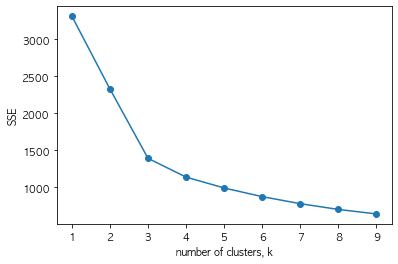

In [0]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

In [0]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init = 1000, max_iter = 3000 ,random_state = 12)
model.fit(people_standard)
model.labels_

array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2,
       2, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0], dtype=int32)

In [0]:
pd.DataFrame(zip(people_total_1.index, model.labels_), columns = ['동', '군집']).sort_values(by = '군집')

,동,군집
20,상계5동,0
19,상계2동,0
0,사직동,1
15,공릉2동,1
14,월계3동,1
13,월계1동,1
11,청운효자동,1
10,숭인2동,1
9,창신3동,1
12,혜화동,1


In [0]:
people_total_3 = pd.merge(people_total.reset_index(), flowtime_preprocessed.reset_index(), left_on = '동', right_on = 'HDONG_NM', how= 'inner').drop('동', axis=1)
people_total_3.set_index('HDONG_NM', inplace = True)
people_total_3.head()

,여_0,여_5,여_10,여_15,여_20,여_25,여_30,여_35,여_40,여_45,...,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23
HDONG_NM,,,,,,,,,,,,,,,,,,,,,
사직동,-0.631768,-0.699226,-0.722735,-0.878286,-0.925807,-0.827011,-0.577635,-0.643946,-0.713332,-0.829253,...,0.925836,0.915103,0.886248,0.962188,0.996802,0.730731,0.760837,0.785073,0.745444,0.572148
부암동,-0.783364,-0.808153,-0.692518,-0.742679,-0.831780,-0.878047,-0.747043,-0.724135,-0.729439,-0.703933,...,-0.177948,-0.181208,-0.135320,-0.134856,-0.229509,-0.247119,-0.244689,-0.184251,-0.186241,-0.273483
평창동,-0.055277,-0.103096,-0.165229,-0.064642,-0.006064,-0.144749,-0.122029,-0.065517,-0.153628,-0.008160,...,0.511950,0.526550,0.559474,0.471879,0.252103,0.459238,0.633552,0.759603,0.910231,1.109765
교남동,-0.296549,-0.548708,-0.645681,-0.815326,-0.855557,-0.563776,-0.364591,-0.420487,-0.578439,-0.760897,...,-0.579120,-0.606709,-0.641159,-0.635407,-0.628572,-0.758652,-0.763620,-0.766114,-0.813808,-0.898957
가회동,-1.078014,-1.119091,-1.061167,-1.121653,-1.264091,-1.291701,-1.157729,-1.180677,-1.151230,-1.185684,...,-0.685611,-0.731934,-0.788480,-0.797626,-0.818949,-0.987704,-1.044253,-1.073191,-1.126653,-1.208418


In [0]:
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k,  init = 'k-means++', n_init = 1500, max_iter = 5000 ,random_state = 12)
    model.fit(people_total_3)
    inertias.append(model.inertia_)
    
inertias

[2610.900703757865,
 1479.5724674075282,
 737.9128223907513,
 494.585091269351,
 362.44638433355533,
 281.3954136990344,
 234.82175877032694,
 200.67141979536805,
 172.07631483694627]

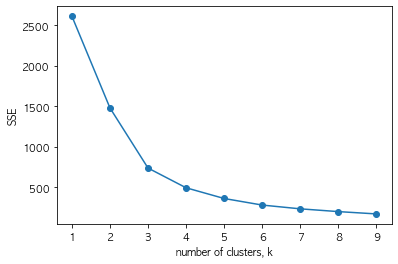

In [0]:
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('SSE')
plt.xticks(ks)
plt.show()

In [0]:
model = KMeans(n_clusters=4, init = 'k-means++', n_init = 1500, max_iter = 5000, random_state = 12)
model.fit(people_standard)
model.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1,
       1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2], dtype=int32)

In [0]:
pd.DataFrame(zip(people_total_3.index, model.labels_), columns = ['동', '군집']).sort_values(by = '군집')

,동,군집
0,사직동,0
15,하계1동,0
14,공릉2동,0
13,월계3동,0
11,혜화동,0
10,청운효자동,0
9,숭인2동,0
8,창신3동,0
12,월계1동,0
6,이화동,0
